In [1]:
# # Colab execute.
# from google.colab import drive


# drive.mount('/content/drive')
# _path = '/content/drive/MyDrive/antenna-performance-prediction/antenna-performance-prediction'
# %cd /content/drive/MyDrive/antenna-performance-prediction/antenna-performance-prediction/

In [7]:
import pandas as pd
import optuna
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
import time
from mylibrary import manipulation
from mylibrary import visualization as visual

# Local execute.
origin_train = pd.read_csv('dataset/train.csv')
origin_test = pd.read_csv('dataset/test.csv')
x_info = pd.read_csv('dataset/meta/x_feature_info.csv')
y_info = pd.read_csv('dataset/meta/y_feature_info.csv')
submission = pd.read_csv("dataset/sample_submission.csv")

# Colab execute.
# origin_train = pd.read_csv(f'{_path}/dataset/train.csv')
# origin_test = pd.read_csv(f'{_path}/dataset/test.csv')
# x_info = pd.read_csv(f'{_path}/dataset/meta/x_feature_info.csv')
# y_info = pd.read_csv(f'{_path}/dataset/meta/y_feature_info.csv')
# submission = pd.read_csv(f'{_path}/dataset/sample_submission.csv')


x_train = origin_train.filter(regex='X')
y_train = origin_train.filter(regex='Y')

x_test = origin_test.drop(columns=['ID'])

x_name = manipulation.make_namegroup(x_train, x_info)
y_name = manipulation.make_namegroup(y_train, y_info)

visual.print_namegroup(x_name)
print()
visual.print_namegroup(y_name)

PCB 체결 시 단계별 누름량(Step n): X_01  X_02  X_05  X_06
방열 재료 n 무게: X_03  X_10  X_11
n차 검사 통과 여부: X_04  X_23  X_47  X_48
방열 재료 n 면적: X_07  X_08  X_09
커넥터 위치 기준 좌표: X_12
각 안테나 패드 위치(높이) 차이: X_13
n번 안테나 패드 위치: X_14  X_15  X_16  X_17  X_18
n번 스크류 삽입 깊이: X_19  X_20  X_21  X_22
커넥터 n번 핀 치수: X_24  X_25  X_26  X_27  X_28  X_29
스크류 삽입 깊이n: X_30  X_31  X_32  X_33
스크류 체결 시 분당 회전수 n: X_34  X_35  X_36  X_37
하우징 PCB 안착부 n 치수: X_38  X_39  X_40
레이돔 치수 (안테나 n번 부위): X_41  X_42  X_43  X_44
안테나 부분 레이돔 기울기: X_45
실란트 본드 소요량: X_46
Cal 투입 전 대기 시간: X_49
RFn 부분 SMT 납 량: X_50  X_51  X_52  X_53  X_54  X_55  X_56

안테나 Gain 평균 (각도n): Y_01  Y_05  Y_07  Y_11
안테나 n Gain 편차: Y_02  Y_03
평균 신호대 잡음비: Y_04
신호대 잡음비 (각도n): Y_06  Y_08  Y_09  Y_10  Y_12  Y_13  Y_14


In [3]:
from sklearn.preprocessing import RobustScaler


# n차 검사 통과 여부
# 모든 값이 1임.
x_train = x_train.drop(columns=x_name['n차 검사 통과 여부'])
x_test = x_test.drop(columns=x_name['n차 검사 통과 여부'])

# 방열 재료 n 무게
# 'X_10','X_11'은 결측값이 절대 다수이고,
# 결측값과 아닌 값 사이의 뚜렷한 차이가 나타나지 않음.
x_train = x_train.drop(columns=['X_10','X_11'])
x_test = x_test.drop(columns=['X_10','X_11'])

# 실란트 본드 소요량
# 'X_46'은 예측하려는 값이나 다른 X값보다 그 크기가 훨씬 크다.
transformer = RobustScaler().fit(x_train[['X_46']])
x_train['X_46'] = transformer.transform(x_train[['X_46']])
x_test['X_46'] = transformer.transform(x_test[['X_46']])

# Cal 투입 전 대기 시간
# 'X_49'는 예측하려는 값이나 다른 X값보다 그 크기가 훨씬 크다.
transformer = RobustScaler().fit(x_train[['X_49']])
x_train['X_49'] = transformer.transform(x_train[['X_49']])
x_test['X_49'] = transformer.transform(x_test[['X_49']])


[[ 6.66884603e-01  0.00000000e+00  2.98507463e-02 ... -3.67226604e-01
  -1.41616906e-01 -5.05028932e-01]
 [ 3.33442301e-01  1.00000000e-03 -3.13432836e-01 ... -3.02510765e-02
   6.50943448e-01 -5.27541511e-01]
 [ 1.33344230e+00  0.00000000e+00 -4.77611940e-01 ... -1.60030347e-01
   2.99524126e-01 -9.21136698e-01]
 ...
 [ 0.00000000e+00  0.00000000e+00 -3.88059701e-01 ...  4.15553564e-01
   3.10755249e-01 -1.37922908e+00]
 [-6.66557699e-01  0.00000000e+00 -5.37313433e-01 ... -3.79981806e-01
  -1.55759183e-01 -5.79946627e-01]
 [-6.66557699e-01  0.00000000e+00 -2.38805970e-01 ...  3.75524069e-01
   2.15442229e-01  1.23787312e+00]]
[[ 0.00000000e+00  1.00000000e-03  1.40298507e+00 ...  2.37537325e-01
  -5.71840180e-01 -9.77593834e-01]
 [-3.33115397e-01  0.00000000e+00  3.13432836e-01 ...  6.35205003e-01
  -5.12898039e-01 -6.31744290e-01]
 [ 3.33442301e-01  0.00000000e+00  2.53731343e-01 ...  2.87645259e-01
  -1.15836016e+00 -2.07886144e+00]
 ...
 [ 3.33442301e-01  0.00000000e+00 -5.3731343

In [4]:
start_t = time.time()

###
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=7)
model = MultiOutputRegressor(xgb_model)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
###
y_pred

end_t = time.time()
t = time.gmtime(end_t - start_t)
print(f"[Training time] => {t.tm_min}(min) {t.tm_sec}(sec)")

[Training time] => 9(min) 25(sec)


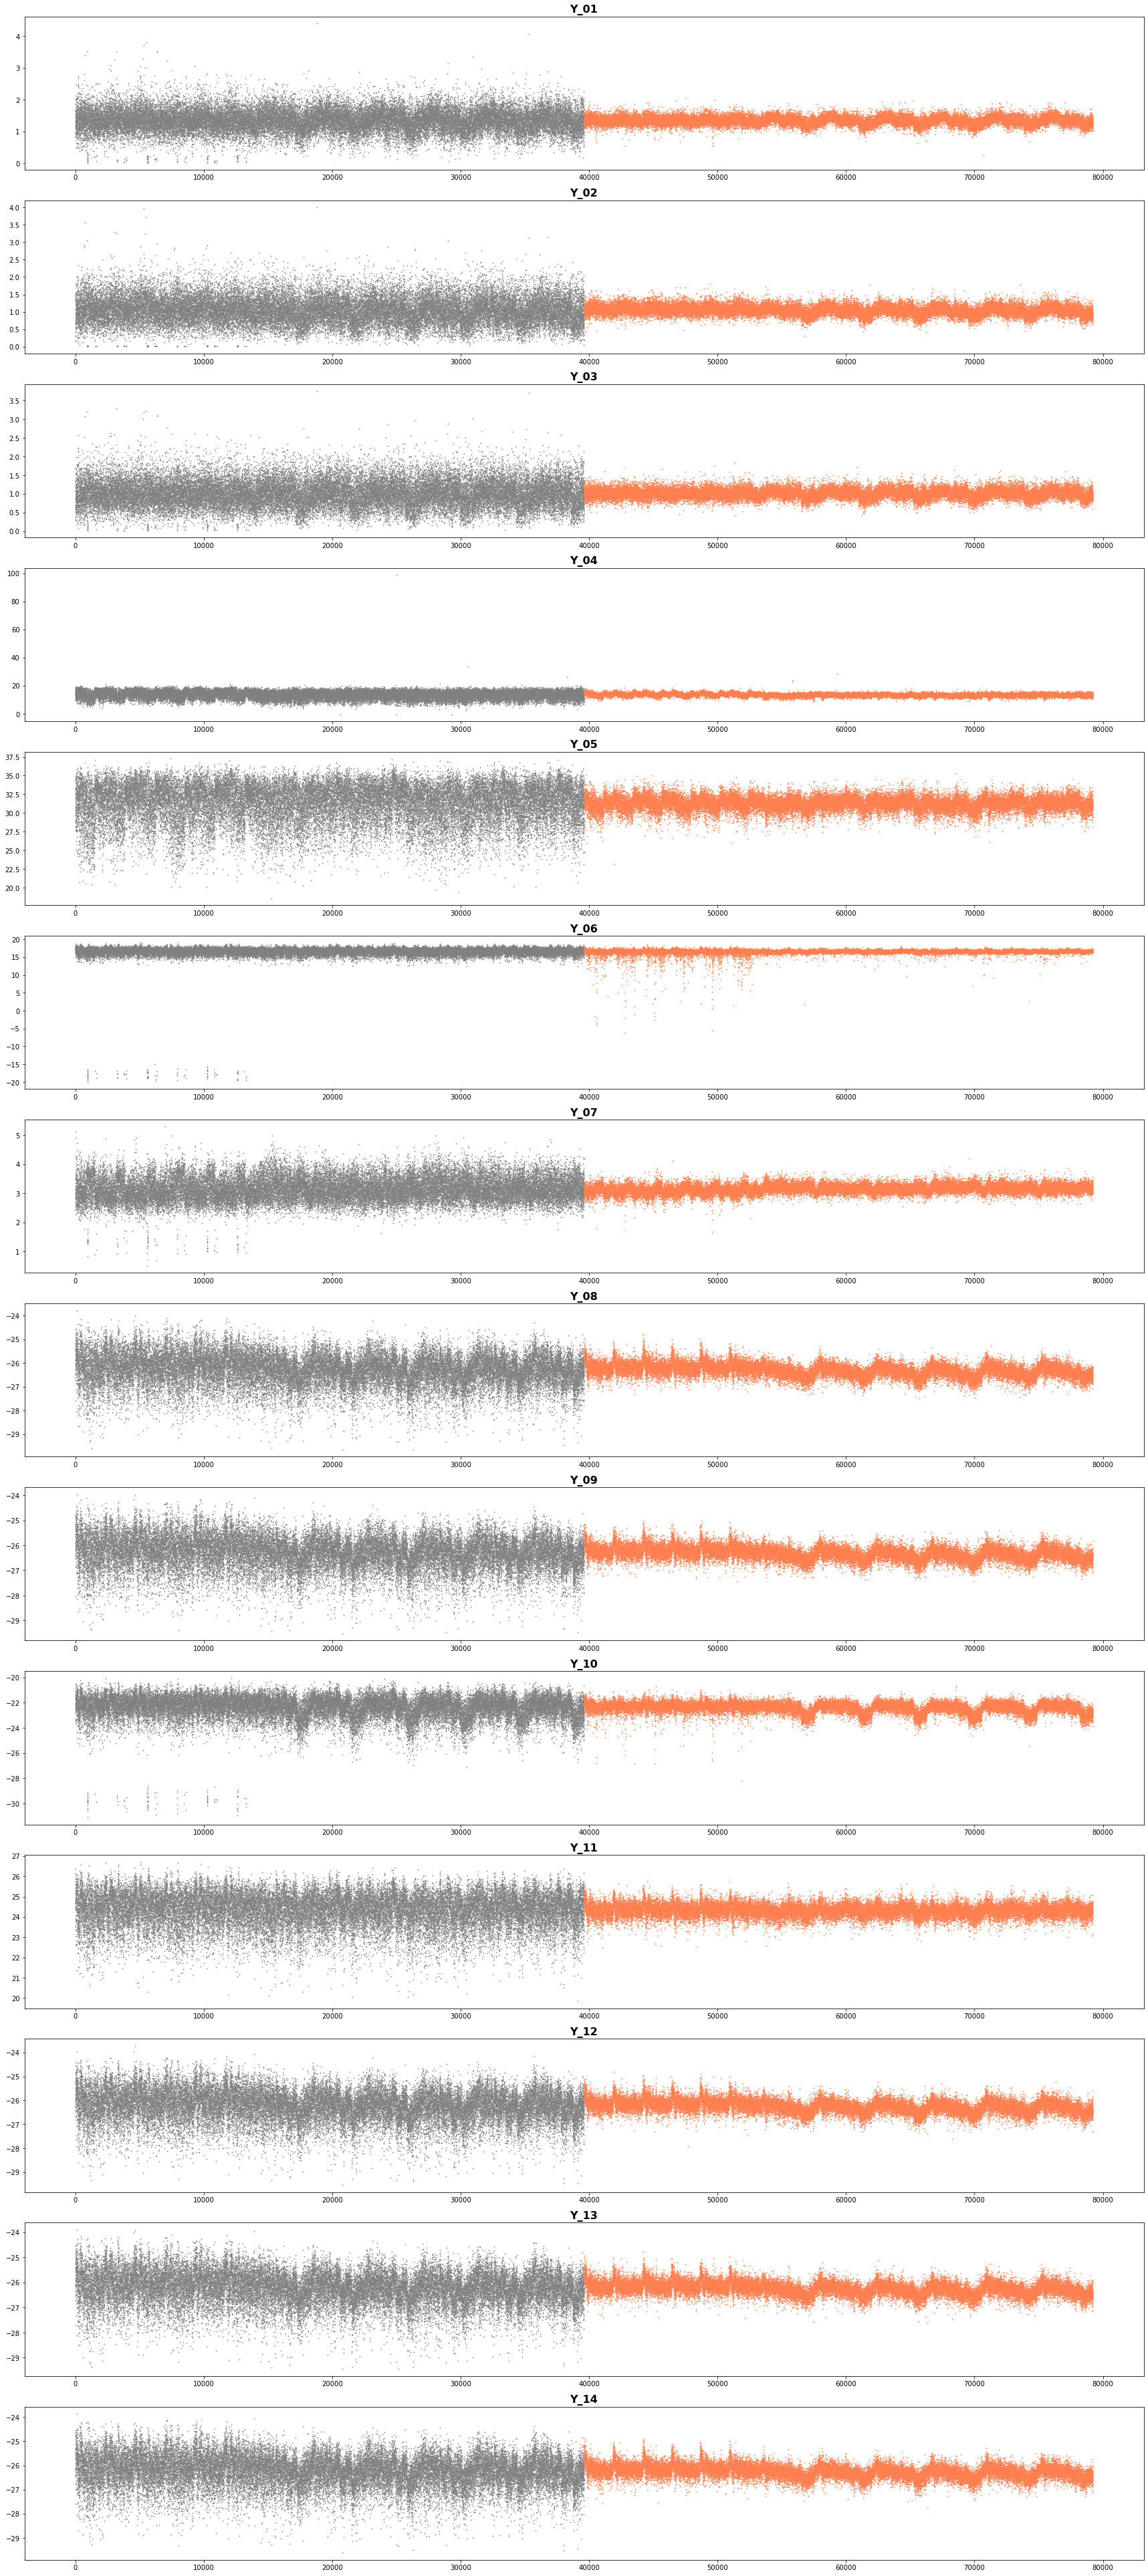

In [5]:
visual.pred_visualize(origin_train.filter(regex='Y'), y_pred)

In [6]:
for idx, col in enumerate(submission.columns):
    if col == 'ID':
        continue
    submission[col] = y_pred[:, idx-1]

submission.to_csv(f"submissions/{time.asctime().replace(':', '-')}.csv", index=False)
print('Done.')

Done.
